In [1]:
import qml
import numpy as np

In [2]:
import pandas as pd

In [3]:
import local_learning

# Learning for penicillin
Should be local models to predict large molecule from smaller ones.

In [4]:
props = pd.read_csv("../opt-amons-penicillin-target/energies.csv", names=['file', 'energy'])

In [5]:
target_energy = float(props[props['file'] == 'penicillin.xyz']['energy'])

In [6]:
target_energy

-1427.0346055

In [7]:
target_mol = qml.Compound("../opt-amons-penicillin-target/penicillin.xyz")

In [8]:
from glob import glob

In [9]:
qm7_xyz = glob('../qm7/*.xyz')

In [10]:
qm7_mols = [qml.Compound(x) for x in qm7_xyz]

In [11]:
qm7_nuclear_charges = np.unique(np.concatenate([x.nuclear_charges for x in qm7_mols]))

In [12]:
target_mol_nuclear_charges = np.unique(target_mol.nuclear_charges)

In [13]:
target_mol_nuclear_charges

array([ 1,  6,  7,  8, 16])

In [14]:
target_rep = qml.representations.generate_fchl_acsf(target_mol.nuclear_charges, 
                                                   target_mol.coordinates, elements=target_mol_nuclear_charges)

In [15]:
qm7_ncharges = np.array([x.nuclear_charges for x in qm7_mols])

In [16]:
qm7_reps = np.array([qml.representations.generate_fchl_acsf(x.nuclear_charges, x.coordinates, 
                                                  elements=target_mol_nuclear_charges, 
                                                            pad=len(target_mol.nuclear_charges))
           for x in qm7_mols])

In [17]:
target_rep.shape

(41, 720)

In [18]:
qm7_reps.shape

(7165, 41, 720)

In [19]:
qm7_props = pd.read_csv("../qm7/energies_qm7.csv", index_col=0)

In [20]:
qm7_labels = [x.split('/')[-1].split('.xyz')[0] for x in qm7_xyz]

In [21]:
qm7_energy = np.array([float(qm7_props[qm7_props['file'] == label]['energy / Ha']) for label in qm7_labels])

# QM7

In [ ]:
import algorithms.local_learning

In [37]:
# to opt hypers

In [36]:
sigma, l2reg = opt_hypers(qm7_reps[:400], qm7_ncharges[:400], qm7_energy[:400], 
                          np.array([target_rep]), np.array([target_mol.nuclear_charges]),
                         np.array([target_energy]))

sigma 10 l2reg 1e-10 mae 8855.006534220829
sigma 10 l2reg 1e-07 mae 8849.389757347471
sigma 10 l2reg 0.0001 mae 8173.279113470638
sigma 100 l2reg 1e-10 mae 1467906.0346661776
sigma 100 l2reg 1e-07 mae 405649.80778634053
sigma 100 l2reg 0.0001 mae 3169.781116087591
sigma 1000 l2reg 1e-10 mae 116082578.61625576
sigma 1000 l2reg 1e-07 mae 408780.2024840259
sigma 1000 l2reg 0.0001 mae 92193.0756641184


NameError: name 'min_sigma' is not defined

In [ ]:
# todo from here 

In [47]:
train_fractions = np.logspace(-1, 0, num=5, endpoint=True)
train_sizes = [int(len(qm7_labels)*x) for x in train_fractions]

In [48]:
lc_maes = []
for i, train_size in enumerate(train_sizes):
    X_train = qm7_reps[:train_size]
    atoms_train = qm7_ncharges[:train_size]
    y_train = qm7_energy[:train_size]
    mae, _ = train_predict_model(X_train, atoms_train, y_train, [target_rep], [target_mol.nuclear_charges],
                                 [target_energy], sigma=sigma, l2reg=l2reg)
    lc_maes.append(mae)

In [49]:
import matplotlib.pyplot as plt

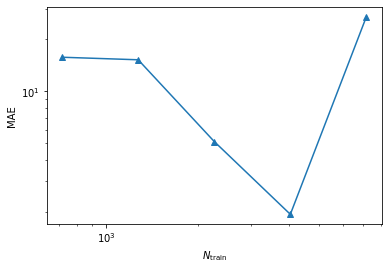

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(train_sizes, lc_maes, marker='^')

ax.set_xlabel("$N_{\mathrm{train}}$")
ax.set_ylabel("MAE")
plt.show()

In [42]:
maes

[15.752277800874253,
 15.226225458612134,
 5.115296827742895,
 1.9357950115254425,
 27.07802873527089]

# Opt selection

In [48]:
opt_labels = list(np.load("../fragments.npy", allow_pickle=True).tolist())

In [49]:
opt_xyz = ['../qm7/'+label+'.xyz' for label in opt_labels]

In [50]:
opt_mols = [qml.Compound(x) for x in opt_xyz]

In [52]:
opt_reps = [qml.representations.generate_fchl_acsf(x.nuclear_charges, x.coordinates, 
                                                  elements=target_mol_nuclear_charges,
                                                  pad=len(target_mol.nuclear_charges))
           for x in opt_mols]

In [53]:
opt_reps = np.array(opt_reps)

In [57]:
opt_ncharges = np.array([x.nuclear_charges for x in opt_mols])

In [54]:
opt_reps.shape

(384, 41, 720)

In [55]:
opt_energy = np.array([float(qm7_props[qm7_props['file'] == label]['energy / Ha']) for label in opt_labels])

In [56]:
opt_energy.shape

(384,)

In [59]:
sigma, l2reg = local_learning.opt_hypers(opt_reps, opt_ncharges, opt_energy, 
                          np.array([target_rep]), np.array([target_mol.nuclear_charges]),
                         np.array([target_energy]))

sigma 10 l2reg 1e-10 mae 14675.633595366675
sigma 10 l2reg 1e-07 mae 14612.48177794967
sigma 10 l2reg 0.0001 mae 9209.207963409168
sigma 100 l2reg 1e-10 mae 617519.9812151014
sigma 100 l2reg 1e-07 mae 187947.9917520971
sigma 100 l2reg 0.0001 mae 732.9356051341902
sigma 1000 l2reg 1e-10 mae 30944889.51414871
sigma 1000 l2reg 1e-07 mae 1194386.7500835739
sigma 1000 l2reg 0.0001 mae 22444.23946960078


NameError: name 'min_sigma' is not defined

# vs amons